# SPATIAL INTERPOLATION

This Jupyter Notebook can be used to play around with the interpolation script that we will experiment on the streamed data in the previous step.

In [1]:
## Import Libraries

import geopandas as gpd
import pandas as pd
import json
import numpy as np
from functools import partial
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata
import geojson

In [2]:
## Read the output of the streamed file

df = pd.read_csv('data/streamed_output.csv').drop(['Unnamed: 0'], axis=1)
df.head()

,lat,lon,value
0,54.750856,9.125586,9.292316
1,53.473352,9.893103,3.009359
2,52.441617,13.417584,9.346951
3,50.958730,11.613320,17.369565
4,49.428931,11.068372,7.866291


In [3]:
# Convert Pandas to GeoPandas
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.set_crs(epsg=4326, inplace=True)
gdf.to_crs(epsg=3035, inplace=True)
gdf.drop(['lon','lat'], axis=1, inplace=True)
gdf.head()

,value,geometry
0,9.292316,POINT (4264678.872 3516455.342)
1,3.009359,POINT (4313901.187 3373954.933)
2,9.346951,POINT (4553301.110 3264594.485)
3,17.369565,POINT (4434343.599 3095401.291)
4,7.866291,POINT (4398513.797 2924567.229)


Plot The Values

<AxesSubplot:>

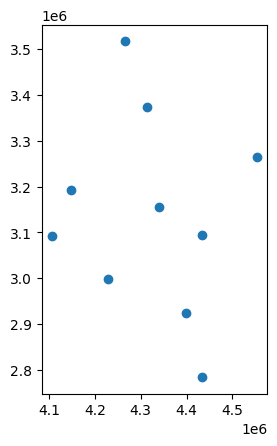

In [4]:
gdf.plot()

The library that we use for interpolation does not directly allow interpolation to a Polygon or is a rather complicated approach. To coutner this, a shapefile "area.geojson" is provided that provides a simpler rectangular extent around Germany.

We first interpolate to this rectangular extent, finally we will crop the boundary of Germany and get a more realistic output

In [5]:
## Read the rectangular extent

with open('data/area.geojson') as f:
    gj = geojson.load(f)
    
geometry = gj['features'][0]['geometry']
geometry

{"coordinates": [[[2.525436, 56.282503], [16.28127, 56.321305], [15.299506, 46.739752], [4.111352, 46.746634], [2.525436, 56.282503]]], "type": "Polygon"}

<AxesSubplot:>

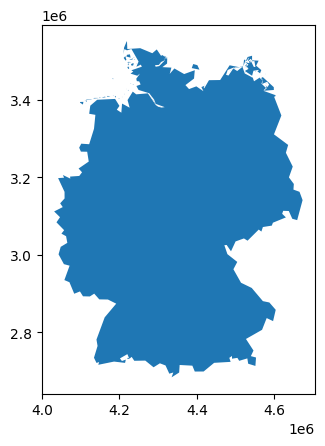

In [6]:
## Plot Germany
germany = gpd.read_file('data/germany_simplified.shp')
germany.to_crs(epsg=3035, inplace=True)
germany.plot()

<AxesSubplot:>

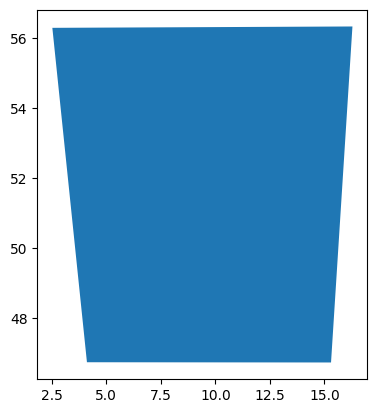

In [7]:
## Plot Rectangular Extent
gpd.read_file('data/area.geojson').plot()

## Interpolation

In this course, we will use Geocube to generate an interpolated surface.
Note: You can use more sophisticated Libraries as well like "PyKrige"

In [8]:
geo_grid_cubic = make_geocube(
    gdf,
    measurements=["value"],
    rasterize_function=partial(rasterize_points_griddata, method="linear", all_touched=True),
    interpolate_na_method="nearest",
    geom=geometry,
    resolution = (-1500,1500) ## Lowering this number will take longer processing time and more memory
)

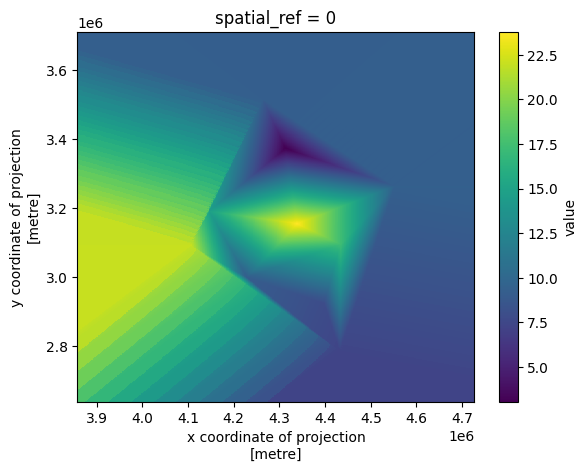

In [9]:
## Plot the Interpolation
geo_grid_cubic.value.plot.imshow()

In [10]:
## Convert xarray (Geocube) output to a DataFrame

output = geo_grid_cubic.to_dataframe().reset_index()
output.head()

,y,x,spatial_ref,value
0,3710250.0,3858750.0,0,9.333685
1,3710250.0,3860250.0,0,9.333685
2,3710250.0,3861750.0,0,9.333685
3,3710250.0,3863250.0,0,9.333685
4,3710250.0,3864750.0,0,9.333685


In [11]:
## Convert this DataFrame to Geopandas

gdf_interpolated = gpd.GeoDataFrame(output, geometry=gpd.points_from_xy(output.x, output.y)).set_crs(epsg=3035)
gdf_interpolated['geometry'] = gdf_interpolated.geometry.buffer(0.0001)
gdf_interpolated.head()

,y,x,spatial_ref,value,geometry
0,3710250.0,3858750.0,0,9.333685,"POLYGON ((3858750.000 3710250.000, 3858750.000..."
1,3710250.0,3860250.0,0,9.333685,"POLYGON ((3860250.000 3710250.000, 3860250.000..."
2,3710250.0,3861750.0,0,9.333685,"POLYGON ((3861750.000 3710250.000, 3861750.000..."
3,3710250.0,3863250.0,0,9.333685,"POLYGON ((3863250.000 3710250.000, 3863250.000..."
4,3710250.0,3864750.0,0,9.333685,"POLYGON ((3864750.000 3710250.000, 3864750.000..."


In [12]:
gdf_interpolated.shape

(413985, 5)

Now we will perform a spatial join, only the region that intersects with the German shapefile will be retained

In [13]:
cropped = germany.sjoin(gdf_interpolated, how="left")[['geometry','value']]
cropped.shape

(158449, 2)

Save Results

In [14]:
# cropped.plot('value', cmap='OrRd') 
## To plot the results, it is recommended to reduce the resolution further down 
## as it uses a lot of memory and might crash your notebook

In [15]:
## Export results to a shapefile (More Time Consuming)
# cropped.to_file('data/interpolated_cropped.shp', driver='ESRI Shapefile')

In [16]:
## Export the rectangular interpolation as raster, quicker to process
geo_grid_cubic.rio.to_raster("data/interpolated_rectangular.tif")

#### END
